In [2]:
import sys, os 
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Input, Conv2D, Activation, Layer, ReLU, Softmax, BatchNormalization, MaxPool2D, Rescaling, CenterCrop, RandomRotation)
import numpy as np 
import cv2 as cv 
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# func to convert .png to .jpg files (.png files have 4 color channels, so regularize input file type with thsi func)
def png_to_jpg(input_dir, output_dir):
    for file in os.listdir(input_dir):
        if file.endswith('.png'):
            filePath = os.path.join(input_dir, file)
            image = cv.imread(filePath)
            output_file = os.path.splitext(file)[0]+".jpg"
            output_filepath = os.path.join(output_dir, output_file)
            cv.imwrite(output_filepath, image)
            os.remove(filePath)
    return

In [4]:
## Read in the images, create class labels, and preprocess for input into CNN ##
#num_classes = 36

path = '/Users/andy/particle_zoo/particle_zoo_org_images' # change image path accordingly

# list to store particle (class) names
particle_types = []

# list to store all particle images. This is what will be randomly shuffled and will be train/validation/test split
images = []

for fileName in os.listdir(path):
    
    if not fileName.startswith("."):
        print(fileName)
        sub_dir_path = os.path.join(path, fileName)
        png_to_jpg(sub_dir_path, sub_dir_path)
        particle_types.append(fileName)
        
        if os.path.isdir(sub_dir_path):
            
            # loop over each file in each sub directory and append to a list of images
            for file in os.listdir(sub_dir_path):
             
                # ignore hidden files that your os may generate
                if not file.startswith('.'):
                    print(file)

                    # create directory path for the image
                    directory = os.path.join(sub_dir_path, file)
                    
                    # read in each image using openCV
                    image = cv.imread(directory)
                    # resize the images accordingly
                    image = cv.resize(image, (75,75))
                    # append to the list we are storing images
                    images.append(image)

antitop quark
IMG_20221202_185454.jpg
20221202_185159.jpg
Screen Shot 2023-02-07 at 9.02.04 AM.jpg
Screen Shot 2023-02-07 at 8.46.08 AM.jpg
20221202_185157.jpg
IMG_20221202_185458.jpg
Screen Shot 2023-02-07 at 9.18.07 AM.jpg
antiup quark
Screen Shot 2023-02-07 at 8.45.53 AM.jpg
IMG_20221202_185256.jpg
IMG_20221202_185312.jpg
Screen Shot 2023-02-07 at 9.02.18 AM.jpg
IMG_20221202_185303.jpg
Screen Shot 2023-02-07 at 9.16.22 AM.jpg
20221202_185725.jpg
20221202_185727.jpg
down quark
Screen Shot 2023-02-07 at 8.45.26 AM.jpg
20221202_185215.jpg
20221202_185219.jpg
Screen Shot 2023-02-07 at 9.17.49 AM.jpg
Screen Shot 2023-02-07 at 9.01.09 AM.jpg
Screen Shot 2023-02-07 at 9.07.05 AM.jpg
charm quark
IMG_20221202_185555.jpg
20221202_185259.jpg
Screen Shot 2023-02-07 at 8.46.23 AM.jpg
Screen Shot 2023-02-07 at 9.17.04 AM.jpg
20221202_185255.jpg
Screen Shot 2023-02-07 at 9.00.46 AM.jpg
positron
Screen Shot 2023-02-07 at 9.17.17 AM.jpg
20221202_185224.jpg
20221202_185226.jpg
Screen Shot 2023-02-07 

In [5]:
# store images and labels in a dictionary
particle_dict = dict.fromkeys(particle_types)

for fileName in os.listdir(path):
    
    if not fileName.startswith("."):
        particle_dict[fileName] = []
        sub_dir_path = os.path.join(path, fileName)
        if os.path.isdir(sub_dir_path):
            
            # loop over each file in each sub directory and append to a list of images
            for file in os.listdir(sub_dir_path):
                # ignore hidden files that your os may generate
                if not file.startswith('.'):
                    directory = os.path.join(sub_dir_path, file)
                    image = cv.imread(directory)
                    image = cv.resize(image,(75,75))
                    particle_dict[fileName].append(image)                   
                    
#train_data, val_data, test_data = train_val_test_split(particle_dict, 0.6, 0.2, 0.2 )
labels = []
for key, value in particle_dict.items():
    for i in range(len(value)):
        labels.append(key)
one_hot_labels = pd.get_dummies(labels).values

images = np.array(images)
        
x_train, x_val, y_train, y_val = train_test_split(images, one_hot_labels, random_state = 1, test_size = 0.2, stratify = one_hot_labels)

x_train, X_test, y_train, Y_test = train_test_split(x_train, y_train, random_state = 1, test_size = 0.25, stratify = y_train)

247
0
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
1
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
2
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
3
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
4
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
5
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
6
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
7
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
8
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
9
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
10
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
11
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
12
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
13
Image Data Type: <class 'numpy.ndarray'>
Image shape: (75, 75, 3)
14
Image Data Type: <class 'numpy.ndarra

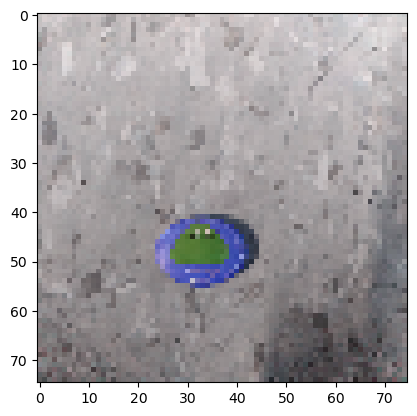

In [6]:
# print out some input data/images and confirm data type (THIS IS UNDERATTED AND OFTEN OVERLLOOKED STEP IN DATA ANALYSIS)
print(len(images))
for i in range(len(images)):
    if type(images[i]) is not None:
        print(i)
        print('Image Data Type:', type(images[i]))
        print('Image shape:', images[i].shape)
plt.imshow(images[0])

In [26]:
## Create your classifier NN. In this case I chose a simple CNN ## 
inputArray = Input((75,75,3))
x = Rescaling(1./255)(inputArray)
X = RandomRotation(0.1)(x)
x = CenterCrop(50,50)(x)
x = Conv2D(filters=1, kernel_size=3)(x)
x = Activation('relu')(x)
x = Conv2D(3, 3)(x)
x = Activation('relu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(3, 3)(x)
x = Activation('relu')(x)
x = MaxPool2D(2,2)(x)
    
x = Flatten()(x)
    
x = Dense(5)(x)
x = Activation('relu')(x)
x = Dense(5)(x)
x = Activation('relu')(x)
x = Dense(36)(x)
outputArray = Activation('softmax')(x)

## create/declare cnn model 
convNet = Model(inputs = inputArray, outputs = outputArray)
convNet.compile(loss = 'categorical_crossentropy',
                metrics = ['accuracy'],
               optimizer = 'adam')
convNet.summary()    

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 75, 75, 3)         0         
                                                                 
 center_crop_7 (CenterCrop)  (None, 50, 50, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 48, 1)         28        
                                                                 
 activation_42 (Activation)  (None, 48, 48, 1)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 46, 46, 3)         30        
                                                                 
 activation_43 (Activation)  (None, 46, 46, 3)         0   

In [32]:
history = convNet.fit(x_train, y_train, epochs = 100, batch_size = 35, validation_data = (x_val, y_val))


Epoch 1/100
5/5 [==============================] - 0s 36ms/step - loss: 1.7913 - accuracy: 0.4218 - val_loss: 10.3620 - val_accuracy: 0.0400
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 1.8078 - accuracy: 0.4558 - val_loss: 12.5827 - val_accuracy: 0.0800
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 1.8520 - accuracy: 0.3741 - val_loss: 10.5609 - val_accuracy: 0.0200
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 1.7932 - accuracy: 0.4694 - val_loss: 11.9255 - val_accuracy: 0.0800
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7987 - accuracy: 0.4150 - val_loss: 10.8663 - val_accuracy: 0.0200
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.7973 - accuracy: 0.4694 - val_loss: 11.7702 - val_accuracy: 0.0800
Epoch 7/100
5/5 [==============================] - 0s 16ms/step - loss: 1.8050 - accuracy: 0.4082 - val_loss: 11.3207 - val_accuracy: 0.0400
Epoch 8/100
5

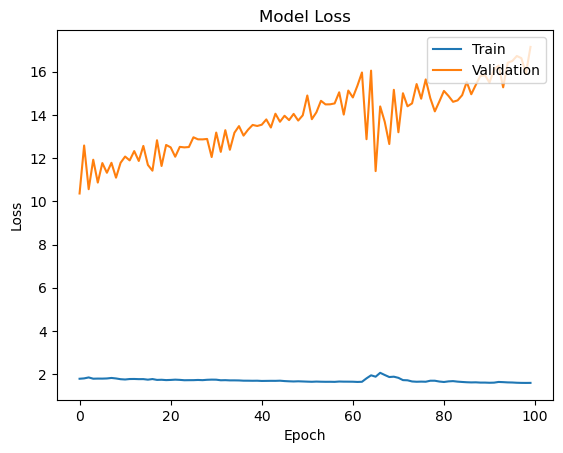

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The above loss curve shows a classical case of overfitting. This can be due to many things, but without more data it is hard to tell what might be causing this CNN to overfit so poorly. Therefore, the next goals are as follows:

The high school students are to generate more data(particle pin images); preprocess the images, download these images, and upload them into this jupyter notebook. 

The undergrads are going to begin optimizing and training various neural network architectures for image classfication on the existing and growing dataset and saving the best trained models. Remember the goal is to deploy this mmodel on an FPGA, so we want a model that has high training and validation accuracy and for the loss funtions per epoch to converge, but we also require the network to not be too large(i.e. not too many parameters and layers. Once this is accomplished, generate ROC curves for the best models so we can analyze performance further. 